## Blockslide 1
### Table of Contents
- OCP Description
- Parameter variables
- Problem specific auxiliary data
- Phases
- Time
- State variables, initialisation and bounds
- Guess
- State equations
- Phase specific auxiliary data
- Path constraints
- Integrand functions
- Objective function
- Settings
- Solve
- Solution

### OCP Description
To first show simple implementation of an optimization in pycollo we will solve a block slide. A block will be pushed in 1D by a force (Fx) an should reach a certain position ending with 0 speed with friction (Ff). The objective is to minimize pushing force. To describe this problem we need two state variables (position x and speed dx), one control variable (Applied force Fx), and three static parameters to describe friction (gravitation g, mass m, and coefficient of friction mu). We will introduce a second order differential to be able to solve the differential equations for the equations of motion.

In [1]:
# 1D Blockslide
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import pycollo

# State variables
x = sym.Symbol("x")  # Position (m) of the point horizontally from the origin (x-axis)
dx = sym.Symbol("dx")  # Velocity (m/s) of the point horizontally (x-axis)
# Control variables
Fx = sym.Symbol("Fx")  # Force (N) applied to the point horizontally (x-axis)

# Static parameter variable
g = sym.Symbol("g")
m = sym.Symbol("m")  # Mass (kg) of the point
mu = sym.Symbol("mu")
# m = 2
# g = 9.81
# mu = 0.5
Ff = m * g * mu

# State equation variables
ddx = sym.Symbol("ddx")  # Acceleration (m/s^2) of the point horizontal (x-axis)

/Users/j.t.heinen/miniconda3/envs/rosetta/lib/python3.10/site-packages/ipopt/__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


### Parameter variables
To initialise an OCP in pycollo start by creating the name and introducing optimised parameters. These are provided in a list or tuple. When these variables are optimised, they will be optimised to a single constant number over all phases. It is good to note that ALWAYS when you want anything to be optimised, make sure bounds and guesses are supplied, otherwise Pycollo cannot run. Bounds can be assigned with list of list, tuples, array, or dictionary.


In [2]:
# Problem instantiation
problem = pycollo.OptimalControlProblem(
    name="Simple Block Slide",
    parameter_variables= (m,mu)
    )
problem.bounds.parameter_variables = [[1,2], [0.5,1]]
problem.guess.parameter_variables = [1.5, 0.75]

### Problem specific auxiliary data
Non optimised static parameters should be assigned a numerical value. This is done through auxiliary data. Auxiliary data is a dictionary where symbols can be assigned to numerical values, or sympy expressions(we will show this later). If you want to exclude the variables from all equations in the OCP, you can make sure the variables are numerical before introducing them into the pycollo.OptimalControlProblem

In [3]:
problem.auxiliary_data = {g: 9.81}

### Phases
The OCP is introduced, now we should start by introducing the phases. Eventhough we are only using a single phase for this OCP, the nature of Pycollo is multiphase, so phases should always be declared.

In [4]:
phase_A = problem.new_phase(name="A")

### Time
Each phase typically has a certain timespan. We wan't the time to start at 0 and will constrain the OCP to do so. By setting a single numerical number the initial time will be 0. Pycollo allows the initial and final time variables to be optimised. When a bound is provided time will be optimised. In this example, we don't know what the final time will be and thus final time will be optimised by a provided bound. A guess should be provided for time. Time guess should minimally be for the initial time and final time, but can expand to as many points as needed by providing a list of n numbers. Make sure to match length n with all other guesses (except for problem.guess.parameter_variables)

In [5]:
phase_A.bounds.initial_time = 0
phase_A.bounds.final_time = [0, 5]
phase_A.guess.time = [0, 1]

### State variables, initialisation and bounds
The phase should know what the state variables and control variables are. Variables should be sympy symbols. Bounds and guesses have to be numerical and cannot include symbolic variables. Bounds are defined as the allowable operating range of the given variables. Bounds can be provided to Pycollo as a list, list of list, tuple of list, numpy array, or dictionary. When the bounds ar supplied with a list, tuple or numpy array, Pycollo will couple the values with by index. Bounds are set outside around the objective with a reasonable amount of play such that the optimisation will not operate at it's bound (unless there is an actual bound in the problem).

In [6]:
phase_A.state_variables = [x, dx]
phase_A.bounds.state_variables = [[-3,3],[-50,50]]

The dictionary is implemented by coupling a lower and upper bound through a list to the variables:

In [7]:
phase_A.bounds.state_variables = {
    x: [-3, 3],
    dx: [-50, 50],
}

Now the optimiser should know where the numerical initial and final state variables of this phase. Once again, when this should be optimised, you can assign a bound to these values, just like the parameter variables. Initial and final state constraints can also be assigned by a list, array or tuple

In [8]:
phase_A.bounds.initial_state_constraints = {
    x: 0,
    dx: 0,
}
phase_A.bounds.final_state_constraints = {
    x: 1,
    dx: 0,
}

### Guess
The state variables are optimised, and thus need a guess. The guess of the state variables should, just like time, minimally include initial and final time. When n number of points is used for the time guess, state_variables guess should have n number of guesses per variable wich match the time by index. Minimal guessing would include initial and final time variables. Guesses are assigned with a list of lists, tuple, or array. Usually a zero guess seed is sufficient in this method. To converge quicker or make sure no local minima is found, proper guessing is needed. 

In [9]:
phase_A.guess.state_variables = [[0, 0], [0, 0]]

### Control variables
The control variables are handeled the same as state variables, but don't need initial and final state constraints:

In [10]:
phase_A.control_variables = [Fx]
phase_A.bounds.control_variables = {
    Fx: [-50, 50],
}
phase_A.guess.control_variables = [
        [0, 0],
    ]


### State equations
The integration over time can only be done when the differential equations of the blockslide are provided to Pycollo. The differential equations can be provided to Pycollo in three ways. First you can provide the equations directly:

In [11]:
phase_A.state_equations = {
    x: dx,
    dx: Fx / m - m*mu,
}

### Phase specific auxiliary data
Secondly, you can provide it through auxiliary data, which results in fundamentally the same solution. Here you can see that auxiliary data can be used to assign expressions to variables. There are two kinds of auxiliary data: 1. Auxiliary data valid for all phases (problem.auxiliary_data) or specific per phase (phase_A.auxiliary_data). This can be helpful because constants can be different per phase.

In [12]:
phase_A.state_equations = {
    x: dx,
    dx: ddx,
}
phase_A.auxiliary_data = {
    ddx: Fx / m - m*mu, 
}
phase_A.guess.control_variables = [
        [0, 0],
    ]

### Path constraints
Thirdly, you can provide state equations with path constraints (also known as, inequality constraints). This is fundamentally different from the previous methods since the equations will be handled in the constraint space. Usually this will result in quicker, less acurate results (depending on NLP tolerance), but is sometimes necesary for example in bang bang control. We will not use this for now because this is not necessary. Later expansion of this example will elaborate on path constraints

In [13]:
# phase_A.path_constraints = [ddx - (Fx / m - m*mu)]
# phase_A.bounds.path_constraints = [0]

### Integrand functions
The only step left is to implement an objective. The objective is to slide the block to the endpoint while minimizing input Fx. To make sure we minimize Fx over the whole time domain we should integrate Fx. To include negative effort in the equation we can square Fx. The bounds should be given for initial and final time, and the guess is a single number, since the output of the function will always result in a single number. 

In [14]:
phase_A.integrand_functions = [Fx ** 2]
phase_A.bounds.integral_variables = [[0, 1000]]
phase_A.guess.integral_variables = [0]


### Objective function
Objective functions should always be a function of initial or final state variables.

In [15]:
problem.objective_function = (
    phase_A.integral_variables[0])

### Settings
Before solving the OCP we can alter Pycollo's default settings such as number of collocation points, amount of mesh sections, NLP tolerance, see al options in [INSERT_LINK_TO_SETTINGS]. For now we will use Pycollo's default sttings and will use it's internal plotting method to show the results. Then we will solve the OCP with:

In [16]:
# Settings
problem.settings.display_mesh_result_graph = True

### Solve


Initialising optimal control problem.

Phase variables and equations checked.
Pycollo variables and constraints preprocessed.
Backend initialised.
Bounds checked.
Problem scaling initialised.
Quadrature scheme initialised.
Backend postprocessing complete.
Initial mesh created.
Initial guess checked.

Initialising mesh iteration #1.

Guess interpolated to iteration mesh in 952.96us.
Scaling initialised in 54.96us.
Initial guess scaled in 4.13us.
Scaling generated in 2.35ms.
NLP generated in 70.66ms.
Mesh-specific bounds generated in 207.33us.

Mesh iteration #1 initialised in 74.23ms.


Solving mesh iteration #1.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***********************************************************************

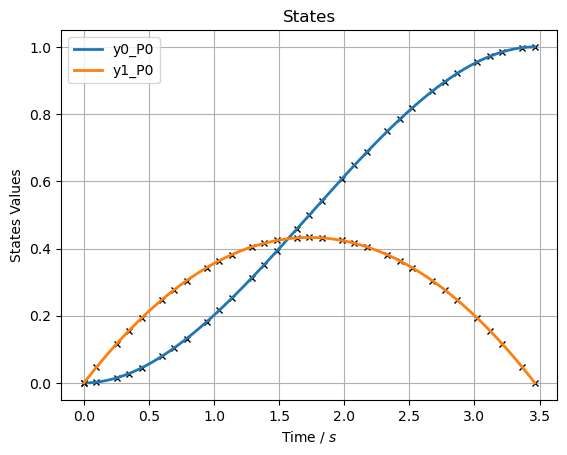

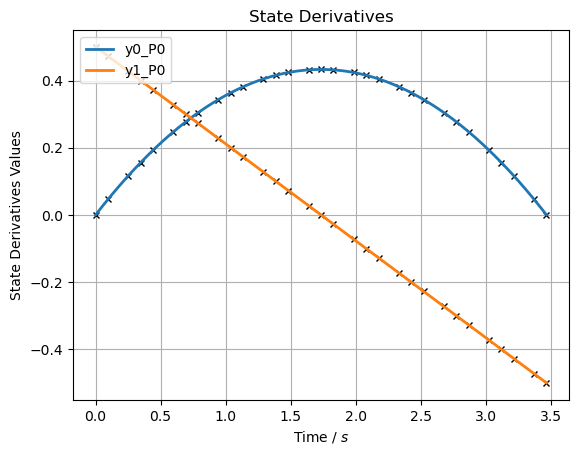

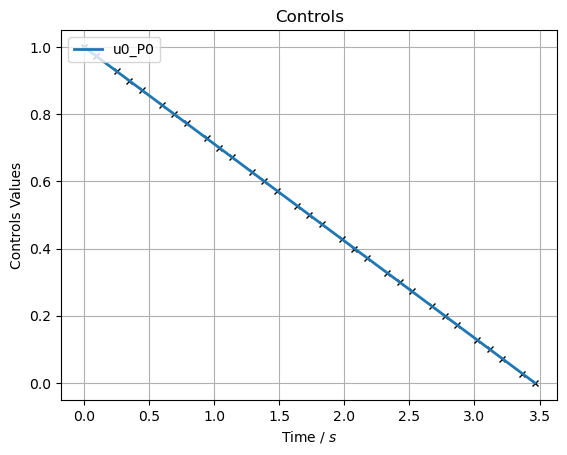

Mesh tolerance met in mesh iteration 1.


Optimal control problem sucessfully solved.

Final Objective Function Evaluation: 1.1547



In [17]:
# Solve
problem.initialise()
problem.solve()

### Solution
All results can be found in problem.solution, see [INSERT_LINK_TO_SOLUTION]